<a href="https://www.kaggle.com/code/sabinakhadysy/pdl-getting-started?scriptVersionId=141481420" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.2.1 which is incompatible.


# Step 1: Import images of dogs and cats

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Search for '{term}'")
    return L(ddg_images(term, max_results = max_images)).itemgot('image')

Checking if I'm getting good results.

In [4]:
urls = search_images('dogs photos', max_images = 1)
urls[0]

Search for 'dogs photos'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'http://static.businessinsider.com/image/5484d9d1eab8ea3017b17e29/image.jpg'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


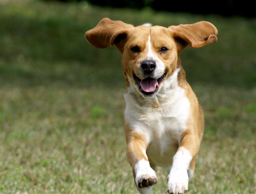

In [5]:
from fastdownload import download_url
dest = 'dog.jpg'
download_url(urls[0], dest)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

Search for 'cat photos'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


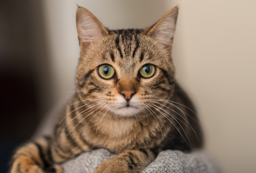

In [6]:
download_url(search_images('cat photos', max_images=1)[0], 'cat.jpg')
Image.open('cat.jpg').to_thumb(256,256)

In [7]:
searches = ('cat', 'dog')
path = Path('cat_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok = True, parents = True )
    download_images(dest, urls = search_images(f'{o} photo'))
    sleep(10) #pause to avoid overloading the server
    download_images(dest, urls = search_images(f'{o} sunny photo'))
    sleep(10)
    download_images(dest, urls = search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size = 400, dest = path/o)

Search for 'cat photo'
Search for 'cat sunny photo'
Search for 'cat shade photo'
Search for 'dog photo'
Search for 'dog sunny photo'
Search for 'dog shade photo'


# Step 2: Training the model

In [8]:
#removing the photos which weren't downloaded correctly in order to aviod model failure while training
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f'{len(failed)} images were incorrect.')

8 images were incorrect.


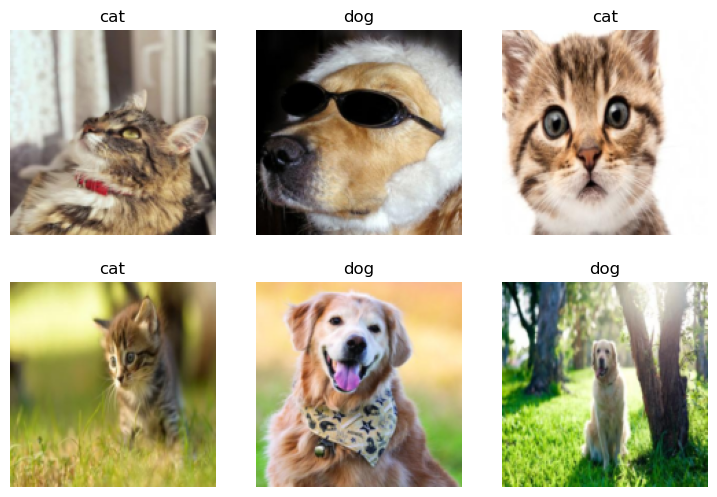

In [9]:
#training the model using DataLoaders
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.3, seed = 47),
    get_y = parent_label,
    item_tfms = [Resize(150, method = 'squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n = 6)